To build a recommender system, we will need the user's rating of the locations. As such, we will be doing a sentiment analysis of the user's caption of his/her Instagram posts and map that to a rating from 1 to 3, with 1 being negative, 2 being neutral and 3 being positive.

## Contents:
- [Installation of Packages](#Installation-of-Packages)
- [Loading of Libraries](#Loading-of-Libraries) 
- [Loading of Datasets & Preprocessing](#Loading-of-Datasets-&-Preprocessing)
- [Sentiment Analysis using Vader](#Sentiment-Analysis-using-Vader)
  - [Compare predicted and true sentiment ratings](#Compare-predicted-and-true-sentiment-ratings)
  - [Overview of dataset](#Overview-of-dataset)

## Installation of Packages

In [1]:
# !pip install vaderSentiment

## Loading of Libraries

In [36]:
# Imports
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
tqdm.pandas()
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer # analyze sentiments using Vader library (implemented from technical paper)
from sklearn.metrics import accuracy_score

## Loading of Datasets & Preprocessing
- Load the dataset from the previous notebook
- Include the `description` (caption) column of the `posts` dataset

In [43]:
# Import dataset after location filter and cleaning
london_profile = pd.read_csv('./output/london_profile_updated.csv')
print(london_profile.shape)
london_profile.head()

(630751, 6)


,name,city,cd,profile_id,location_id,cts
0,la famiglia,"London, United Kingdom",GB,4.519805e+06,1178180.0,2016-06-09 22:13:32.000
1,la famiglia,"London, United Kingdom",GB,2.594847e+08,1178180.0,2019-05-30 23:17:22.000
2,la famiglia,"London, United Kingdom",GB,6.364797e+09,1178180.0,2019-05-26 15:27:27.000
3,green park,"London, United Kingdom",GB,2.213894e+08,857670431.0,2019-05-30 21:41:15.000
4,green park,"London, United Kingdom",GB,6.243066e+08,857670431.0,2019-05-30 07:56:50.000


In [44]:
london_profile.drop_duplicates(inplace=True)

In [45]:
# Extract required cols
london_profile = london_profile[['profile_id', 'name', 'location_id', 'cts']]

In [46]:
# Check datatypes
london_profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 630725 entries, 0 to 630750
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   profile_id   630725 non-null  float64
 1   name         630725 non-null  object 
 2   location_id  630725 non-null  float64
 3   cts          630725 non-null  object 
dtypes: float64(2), object(2)
memory usage: 24.1+ MB


In [47]:
# Change cts column to datetime dtype
london_profile['cts']= pd.to_datetime(london_profile['cts'])

In [48]:
# Check changes
london_profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 630725 entries, 0 to 630750
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   profile_id   630725 non-null  float64       
 1   name         630725 non-null  object        
 2   location_id  630725 non-null  float64       
 3   cts          630725 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 24.1+ MB


In [49]:
# Import and read posts dataset in chunks
posts_chunk = pd.read_csv(r'./output/posts.csv', chunksize=1000000, engine='python')

In [50]:
def chunk_preprocessing(chunk):
    # Change cts column to datetime dtype
    chunk['cts']=pd.to_datetime(chunk['cts'])
    # Inner merge the two dataframes
    location_profile_desc = pd.merge(london_profile, chunk, on=['profile_id', 'location_id', 'cts'], how='inner')
    return location_profile_desc

In [ ]:
%%time
chunk_list =[] # append each chunk df here

for chunk in tqdm(posts_chunk):
    # perform model filtering
    chunk_filter = chunk_preprocessing(chunk)
    
    # append chunk to list
    chunk_list.append(chunk_filter)
    
# concat the list into dataframe
df_concat = pd.concat(chunk_list)

## Sentiment Analysis using Vader
- To do a sentiment analysis on the `description` column, we will make use of the vader package.
- We will check for the accuracy of the sentiment rating by Vader by comparing 100 rows of data with a hand-labelled rating before proceeding with using the package.

In [14]:
# Save and export first 100 rows for sentiment analysis comparison
posts100 = df_concat.head(100)
posts100.to_csv('./output/posts100.csv', index=False)

In [15]:
# Instantiate analyzer
analyzer = SentimentIntensityAnalyzer()

In [16]:
%%time
# Find the predicted value of sentiment
def vader_sentiment_pred(description):
    vader_output = analyzer.polarity_scores(description)
    
    # based on vader_sentiment documentation on polarity scores
    if vader_output['compound'] <= -0.05: 
        # negative sentiment
        return 1
    elif (vader_output['compound'] > -0.05) and (vader_output['compound'] <0.05):
        # neutral sentiment
        return 2
    else:
        # positive sentiment
        return 3

df_concat['sentiment_pred'] = df_concat['description'].apply(vader_sentiment_pred) # call function to apply Vader sentiment prediction on ALL descriptions in dataset
df_concat.head()

CPU times: user 1min 35s, sys: 9.94 s, total: 1min 45s
Wall time: 2min 36s


,profile_id,location_id,cts,description,sentiment_pred
0,4.519805e+06,1178180.0,2016-06-09 22:13:32,Today has been fuelled by incredible meals (re...,3
1,2.594847e+08,1178180.0,2019-05-30 23:17:22,I love you baby and if it’s quite alright oh E...,3
2,6.364797e+09,1178180.0,2019-05-26 15:27:27,#friendzoned 💙 @lafamiglia.sw10 ⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀ ⠀...,3
3,2.213894e+08,857670431.0,2019-05-30 21:41:15,S U M M E R 🔜☀️,2
4,6.243066e+08,857670431.0,2019-05-30 07:56:50,"TBT!! Only a few days ago, but what a vibe and...",3


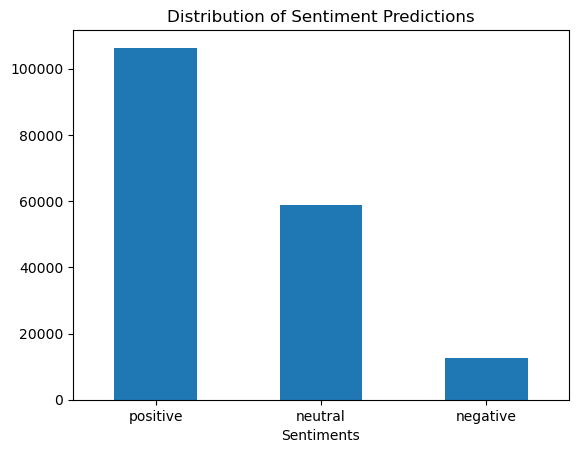

In [33]:
# Plot distribution of sentiment_pred
df_concat['sentiment_pred'].value_counts().plot(kind='bar', rot=0, title='Distribution of Sentiment Predictions')
plt.xticks(ticks=[0,1,2], labels=['positive','neutral','negative'])
plt.xlabel("Sentiments")
plt.show();

- Most of the sentiments in the dataset are positive.

#### Compare predicted and true sentiment ratings

In [17]:
# Save and export first 100 rows for sentiment analysis comparison
posts100_pred = df_concat.head(100)
posts100_pred.to_csv('./output/posts100_pred.csv', index=False)

In [36]:
# Load true (hand labelled) sentiment rating
posts100_true = pd.read_csv('./output/posts100_true.csv')
print(posts100_true.shape)
posts100_true.head()

(100, 5)


,profile_id,location_id,cts,description,sentiment
0,4519805,1178180,2016-06-09 22:13:32,Today has been fuelled by incredible meals (re...,3
1,259484657,1178180,2019-05-30 23:17:22,I love you baby and if it’s quite alright oh E...,2
2,6364796956,1178180,2019-05-26 15:27:27,#friendzoned 💙 @lafamiglia.sw10 ⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀ ⠀...,3
3,221389356,857670431,2019-05-30 21:41:15,S U M M E R 🔜☀️,2
4,624306558,857670431,2019-05-30 7:56:50,"TBT!! Only a few days ago, but what a vibe and...",3


In [38]:
# Change cts to datetime dtype
posts100_true['cts']=pd.to_datetime(posts100_true['cts'])

In [43]:
# Merge true and predicted sentiment dataset
posts100 = posts100_true.merge(posts100_pred)

In [44]:
posts100.head()

,profile_id,location_id,cts,description,sentiment,sentiment_pred
0,4519805,1178180,2016-06-09 22:13:32,Today has been fuelled by incredible meals (re...,3,3
1,259484657,1178180,2019-05-30 23:17:22,I love you baby and if it’s quite alright oh E...,2,3
2,6364796956,1178180,2019-05-26 15:27:27,#friendzoned 💙 @lafamiglia.sw10 ⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀ ⠀...,3,3
3,221389356,857670431,2019-05-30 21:41:15,S U M M E R 🔜☀️,2,2
4,624306558,857670431,2019-05-30 07:56:50,"TBT!! Only a few days ago, but what a vibe and...",3,3


In [45]:
# Check accuracy of sentiment rating prediction
accuracy_score(posts100['sentiment'].values, posts100['sentiment_pred'].values)

0.8080808080808081

- Based on a hand labelled sentiment rating of the first 100 rows from the description column, there is a 81% accuracy in the predicted sentiment rating using the SentimentIntensityAnalyzer from Vader. As such, we will proceed to using the predicted sentiment rating.

In [47]:
# Drop description column
recsys_df = df_concat.drop('description', axis=1)
print(recsys_df.shape)
recsys_df.head()

(177609, 4)


,profile_id,location_id,cts,sentiment_pred
0,4.519805e+06,1178180.0,2016-06-09 22:13:32,3
1,2.594847e+08,1178180.0,2019-05-30 23:17:22,3
2,6.364797e+09,1178180.0,2019-05-26 15:27:27,3
3,2.213894e+08,857670431.0,2019-05-30 21:41:15,2
4,6.243066e+08,857670431.0,2019-05-30 07:56:50,3


In [48]:
# Save and export
recsys_df.to_csv('./output/recsys_df.csv', index=False)

#### Overview of dataset

- We now have profile_id, location_id and sentiment rating, sufficient to build a collaborative-filtering recommender system.
- However, such a recommender system will suffer from a cold start problem.
- As such, we will next attempt to use a zero shot package to find the location types based on the location names in an attempt to build a hybrid recommender system (collaborative-filtering with content-based filtering).